# RAGAS Basic
1. 지식그래프 분석
   * MultiHopSpecific Type에 사용되는 OverlapScoreBuilder Relation의 문제 발견
   * OverlapScoreBuilder는 Named Entity(사람, 조직, 장소 등 고유한 이름) 추출을 기반으로 관계를 형성
   * Named Entity의 섹션 간 분포가 불균형한 것으로 분석됨
     - Named Entity별 타 섹션 분포 분석 결과, 대부분의 Entity가 동일 섹션 내에 집중되어 있는 것으로 확인됨
     - 이는 문서의 구조적 특성과 Named Entity의 분포 특성에 기인하는 것으로 파악됨
   * 이로 인해 OverlapScoreBuilder 기반 관계의 수가 매우 제한적이며, 섹션 간 network density가 낮은 것으로 파악됨
   * MultiHopSpecificQuery Type의 문제점 분석
      * 질의 생성이 동일 섹션 결합에 과도하게 의존하는 것으로 확인됨
      * 이는 다양한 섹션 간의 관계를 활용한 질의 생성이 제한되는 결과로 이어짐
2. MultiHopAbstractQuerySynthesizer 최적화 필요
   * 기존: 매번 관계를 순회하며 이웃노드 검색
   * 개선방안: 이웃 노드 맵을 통해 한 번의 순회로 모든 관계 처리
3. 생성 페르소나와 실제 사용자 간의 불일치 발생
   * 생성 페르소나는 문서 요약을 기반으로 생성됨
   * 요약을 기반으로 해당 요약 콘텐츠와 상호작용하거나 혜택을 받을 가능성이 있는 단일 페르소나를 생성함
   * 이로 인해 문서 독자와 RAG 예상 사용자 간의 특성 차이가 발생하는 것으로 파악됨
   * 이는 생성된 페르소나가 실제 사용자 그룹을 충분히 대표하지 못하는 결과로 이어짐

In [1]:
import os
import json
from tqdm import tqdm
import pandas as pd

from dotenv import load_dotenv
load_dotenv()

from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
with open('../data/rag/chunk_with_overlap.json', 'r', encoding='utf-8') as f:
    origin_data = json.load(f)


total_data = []
for data in origin_data:
    total_data.extend(data)

print(len(total_data))

255


## 1. 지식 그래프 생성

In [3]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType

generator_llm = LangchainLLMWrapper(ChatOpenAI(model='gpt-4o-mini'))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

c:\Users\owner\anaconda3\envs\SportAgent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_core.documents import Document

kg = KnowledgeGraph()

for doc in total_data:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={'page_content': doc['page_content'],
                        'document_metadata': doc['metadata']}
        )
    )

In [5]:
from ragas.testset.transforms import apply_transforms
from ragas.testset.transforms.extractors.embeddings import EmbeddingExtractor
from ragas.testset.transforms.extractors.llm_based import (
    SummaryExtractor,
    ThemesExtractor,
    NERExtractor
)
ner_extractor = NERExtractor(llm=generator_llm)
summary_extractor = SummaryExtractor(llm=generator_llm)
themes_extractor = ThemesExtractor(llm=generator_llm)
embedding_extractor = EmbeddingExtractor(
    embedding_model=generator_embeddings,
    property_name="summary_embedding",
    embed_property_name="summary",
    filter_nodes=lambda node: node.get_property("summary") is not None
)

transforms = [
    ner_extractor,
    summary_extractor,
    themes_extractor,
    embedding_extractor
]

# apply_transforms(kg, transforms)

In [11]:
from ragas.testset.transforms.relationship_builders import (
    CosineSimilarityBuilder,
    OverlapScoreBuilder,
)

cosine_sim_builder = CosineSimilarityBuilder(
    property_name="summary_embedding",
    new_property_name="summary_similarity",
    threshold=0.7
)

relation_builder = OverlapScoreBuilder(
    property_name="entities",
    new_property_name="overlap_score",
    threshold=0.01,
    distance_threshold=0.9,
)

transforms = [cosine_sim_builder, relation_builder]
apply_transforms(kg, transforms)

In [4]:
# kg.save('../data/rag/kg.json')
kg = KnowledgeGraph.load('../data/rag/kg.json')

## 2. knowledge graph 분석 

### 2-1. knowledge graph의 nodes 분석
* 분석항목
  * 전체 문서 내 최빈 entity
  * 각 단원(sector)별 최빈 entity
  * 각 단원별 비검출 node 수
* 현황 분석
  * NERExtractor 특징
    * NERExtractor는 일반 entity가 아닌 named entity를 추출함
    * named entity는 고유명사로 특정 이름을 가진 개체로, 주로 사람, 장소, 조직, 날짜/시간 등을 대상으로 함
  * 시사점
    * 최빈 상위 10개 entity 분석 결과, '바벨', '역도', '무릎', '역도선수', '심리기술훈련' 등 사용자 예상 질문과 관련성이 적은 entity가 주로 추출
    * 섹터별 상위 entity 분포 결과, 문서 전체에 분포하는 entity가 부재

In [14]:
def analyze_node_entity(kg, entity_name=None):
    # 데이터 구조 초기화
    sector_null = {}
    sector_total = {}
    sector_entities = {}
    total_entities = []
    sectors_order = []
    total_node_count = len(kg.nodes)
    null_node_count = 0

    # 데이터 수집
    for node in kg.nodes:
        sector = node.properties['document_metadata']['heading']['heading1']
        if entity_name != None:
            entities = node.properties['exercise_entities'].get(entity_name, [])
        else:
            entities = node.properties.get('entities', [])
        if sector not in sectors_order:
            sectors_order.append(sector)
        if sector not in sector_null:
            sector_null[sector] = 0
            sector_total[sector] = 0
            sector_entities[sector] = []
        sector_total[sector] += 1
        if not entities:
            sector_null[sector] += 1
            null_node_count += 1
        else:
            sector_entities[sector].extend(entities)
            total_entities.extend(entities)

    # 전체 entity 없는 노드 비율 계산
    null_ratio = null_node_count / total_node_count * 100

    # 섹터별 entity 없는 노드 비율 계산
    sector_null_ratio = {sector: sector_null[sector] / sector_total[sector] * 100 for sector in sectors_order}

    # 전체 상위 10개 entity
    total_entity_counts = Counter(total_entities)
    top_total_entities = dict(sorted(total_entity_counts.items(), key=lambda x: x[1], reverse=True)[:10])

    # 섹터별 상위 5개 entity
    sector_top_entities = {}
    for sector in sectors_order:
        counts = Counter(sector_entities[sector])
        sector_top_entities[sector] = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5])

    # 시각화
    plt.figure(figsize=(15, 10))

    # 1. 섹터별 entity 없는 노드 비율 막대그래프
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(sector_null_ratio.keys(), sector_null_ratio.values(), color='skyblue')
    plt.ylabel('비율(%)')
    plt.title(f'섹터별 Entity 없는 노드 비율\n(전체 노드 중 entity 없는 노드 비율: {null_ratio:.1f}%)')
    plt.xticks(rotation=45, ha='right')
    # 막대 위에 값 표시
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height:.1f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3pt 위에
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. 전체 상위 10개 entity 막대 그래프
    plt.subplot(2, 2, 2)
    bars2 = plt.bar(top_total_entities.keys(), top_total_entities.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('전체 상위 10개 Entity')
    # 막대 위에 값 표시
    for bar in bars2:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 3. 섹터별 상위 entity 히트맵 (깔끔하게)
    plt.subplot(2, 1, 2)
    sectors = list(sector_top_entities.keys())
    all_entities = sorted({e for ents in sector_top_entities.values() for e in ents})
    heatmap_data = np.zeros((len(sectors), len(all_entities)))
    for i, sector in enumerate(sectors):
        for j, entity in enumerate(all_entities):
            heatmap_data[i, j] = sector_top_entities[sector].get(entity, 0)

    im = plt.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')

    # 컬러바
    cbar = plt.colorbar(im, label='출현 빈도')
    cbar.ax.tick_params(labelsize=10)

    # x, y축 라벨
    plt.xticks(range(len(all_entities)), all_entities, rotation=45, ha='right', fontsize=10)
    plt.yticks(range(len(sectors)), sectors, fontsize=10)
    plt.xlabel('Entity', fontsize=12)
    plt.ylabel('Sector', fontsize=12)
    plt.title('섹터별 상위 Entity 분포', fontsize=14, pad=15)

    # value annotation (0이 아닌 값만)
    for i in range(len(sectors)):
        for j in range(len(all_entities)):
            value = int(heatmap_data[i, j])
            if value > 0:
                plt.text(j, i, str(value), ha='center', va='center', color='black', fontsize=9, fontweight='bold')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # 비율 텍스트로도 출력
    print(f"전체 노드 수: {total_node_count}")
    print(f"Entity가 없는 노드 수: {null_node_count}")
    print(f"전체 노드 중 entity가 없는 노드 비율: {null_ratio:.1f}%")

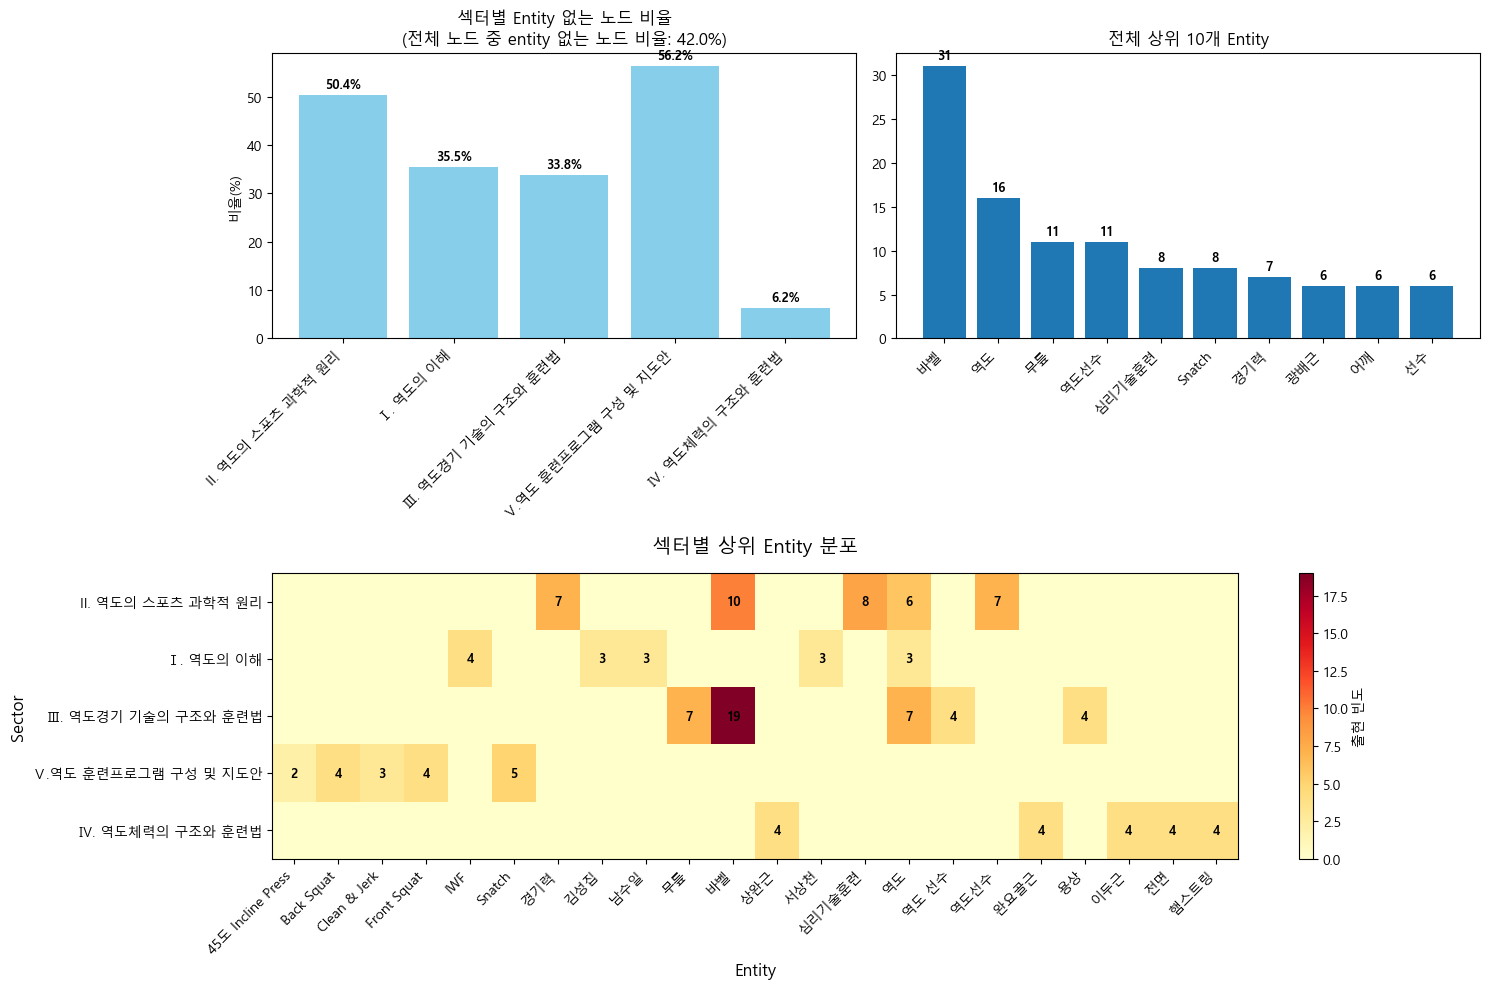

전체 노드 수: 255
Entity가 없는 노드 수: 107
전체 노드 중 entity가 없는 노드 비율: 42.0%


In [15]:
analyzed_result = analyze_node_entity(kg)

### 2-2. knowledge graph의 relationships 분석
* defualt_transforms의 relationship 형성 과정
  * OverlapScoreBuilder relationship
    * 모든 노드의 entities를 집계 후, 상위 5% entities를 noisy로 활용하여 관계 설정 과정에서 배제
    * 두 노드의 공통된 entity 정도에 따라 relationship 형성 유무 결정    
  * Cosine_Similarity relationship
    * 두 노드의 summary embedding의 cosine similarity에 따라 relationship 형성 유무 결정
    * 유사도에 대한 threshold 기본 설정값은 0.7
* default_transforms의 결과, 타 section 과의 relationship 정도 분석
  * Cosine_Similarity relationship의 타 섹션 관계 비율은 66.6%
  * Overlap relationship의 경우 타 섹션 비율은 37.2%
* relationship 분포 분석
  * Overlap relationship은 전체 231개 존재(동일 섹션: 145, 타 섹션: 86)
  * Cosine_Similarity relationship은 전체 31,984개 존재(동일 섹션: 10,668, 타 섹션: 21,316)

* 시사점
  * 타 섹션간 relationship
    * Cosine_Similarity relationship은 타 섹션과의 비율도 높으나, 섹터간 매우 높은 network density를 가짐
    * overlap relationship은 운동과 관련된 entity 추출이 아닌 범용적인 name entity 추출 기반 relation 형성 과정
    * 그로 인해 overlap relationship의 수 자체도 매우 적으며, 섹터간 network density와 타 섹션간 비율도 낮음
  * relationship 분포 차이
    * 두 타입의 relationship 간 분포의 차이가 크게 나타남(약 138배)
    * 문서의 특성상 문서간 유사도는 ragas가 제안한 범용적 기준(0.7)보다 대부분 높음
    * 기본 threshold 설정값인 0.7이 아닌 문서내 문서의 특성을 반영해, threshold 설정값 조정 필요   

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import List, Dict, Any

def analyze_relationship(
    kg: Any,
    rel_types: List[str] = None,
    figsize: tuple = (7, 5),
    colors: List[str] = ['#4F81BD', '#C0504D'],
    show_plot: bool = True,
    heading: str = 'heading1'
) -> Dict[str, Dict[str, int]]:
    """
    지식 그래프의 관계를 분석하고 시각화합니다.

    Args:
        kg: 지식 그래프 객체
        rel_types: 분석할 관계 타입 리스트
        figsize: 그래프 크기
        colors: 막대 그래프 색상
        show_plot: 그래프 표시 여부

    Returns:
        Dict[str, Dict[str, int]]: 관계 통계 정보
    """
    # 기본 관계 타입 설정
    if rel_types is None:
        rel_types = ['entities_overlap', 'cosine_similarity']

    # 노드 id → 섹션명 매핑
    node_sector = {}
    for node in kg.nodes:
        try:
            node_id = node.id.hex
            sector = node.properties['document_metadata']['heading'][heading]
            node_sector[node_id] = sector
        except (AttributeError, KeyError) as e:
            print(f"Warning: Node {node_id} has invalid structure: {e}")
            continue

    # 통계 변수 초기화
    stats = {rtype: {'total': 0, 'same_sector': 0, 'diff_sector': 0} for rtype in rel_types}
    sector_rel_count = defaultdict(int)

    # 관계 순회하며 통계 집계
    for rel in kg.relationships:
        try:
            rel_type = getattr(rel, 'type', rel.__dict__.get('type', ''))
            source_id = rel.__dict__['source'].id.hex
            target_id = rel.__dict__['target'].id.hex
            source_sector = node_sector.get(source_id, 'Unknown')
            target_sector = node_sector.get(target_id, 'Unknown')

            sector_rel_count[source_sector] += 1
            sector_rel_count[target_sector] += 1

            if rel_type not in stats:
                continue

            stats[rel_type]['total'] += 1
            if source_sector == target_sector:
                stats[rel_type]['same_sector'] += 1
            else:
                stats[rel_type]['diff_sector'] += 1
        except (AttributeError, KeyError) as e:
            print(f"Warning: Invalid relationship structure: {e}")
            continue

    if show_plot:
        for rtype in rel_types:
            plt.figure(figsize=figsize)
            same_count = stats[rtype]['same_sector']
            diff_count = stats[rtype]['diff_sector']
            total = stats[rtype]['total']

            plt.bar(['동일 섹션', '타 섹션'], 
                   [same_count, diff_count], 
                   color=colors)

            for i, v in enumerate([same_count, diff_count]):
                percentage = (v/total*100) if total > 0 else 0
                plt.text(i, v, f'{v} ({percentage:.1f}%)', 
                        ha='center', va='bottom', 
                        fontsize=11, fontweight='bold')

            plt.title(f'{rtype} 관계 분포', fontsize=14)
            plt.ylabel('관계 개수')
            plt.tight_layout()
            plt.show()

    return stats

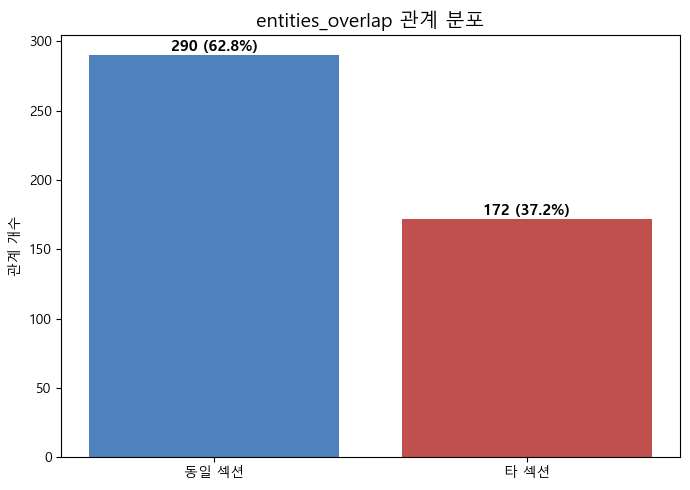

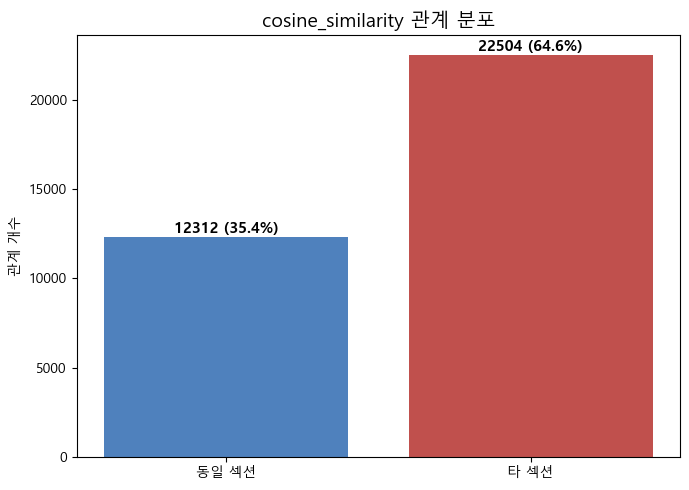

{'entities_overlap': {'total': 462, 'same_sector': 290, 'diff_sector': 172},
 'cosine_similarity': {'total': 34816,
  'same_sector': 12312,
  'diff_sector': 22504}}

In [17]:
analyze_relationship(kg)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Union

def analyze_sector_connection_ratio(
    kg: Any,
    rel_types: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (16, 6),
    color_maps: Optional[Dict[str, str]] = None,
    return_dfs: bool = True,
    show_plot: bool = True
) -> Union[Tuple[pd.DataFrame, ...], None]:
    """
    섹터 간 연결 비율을 분석하고 시각화합니다.

    Args:
        kg: 지식 그래프 객체
        rel_types: 분석할 관계 타입 리스트
        figsize: 그래프 크기
        color_maps: 관계 타입별 컬러맵 딕셔너리
        return_dfs: DataFrame 반환 여부
        show_plot: 그래프 표시 여부

    Returns:
        Optional[Tuple[pd.DataFrame, ...]]: 관계 타입별 연결 비율 DataFrame
    """
    # 기본값 설정
    if rel_types is None:
        rel_types = ['cosine_similarity', 'entities_overlap']
    
    if color_maps is None:
        color_maps = {rtype: 'YlOrRd' for rtype in rel_types}

    # 노드 id → 섹터명 매핑 및 섹터별 노드 id 집합
    node_sector = {}
    sector_nodes = defaultdict(set)
    
    try:
        for node in kg.nodes:
            node_id = node.id.hex
            sector = node.properties['document_metadata']['heading']['heading1']
            node_sector[node_id] = sector
            sector_nodes[sector].add(node_id)
    except (AttributeError, KeyError) as e:
        print(f"Warning: Error processing nodes: {e}")
        return None

    sectors = sorted(sector_nodes.keys())
    n = len(sectors)

    # 관계 타입별 실제 관계 수 매트릭스
    actual_matrices = {rtype: np.zeros((n, n), dtype=int) for rtype in rel_types}
    # 가능한 최대 관계 수 매트릭스
    max_matrix = np.zeros((n, n), dtype=int)

    # 관계 집계
    for rel in kg.relationships:
        try:
            rel_type = getattr(rel, 'type', rel.__dict__.get('type', ''))
            source_id = rel.__dict__['source'].id.hex
            target_id = rel.__dict__['target'].id.hex
            source_sector = node_sector.get(source_id, 'Unknown')
            target_sector = node_sector.get(target_id, 'Unknown')
            
            if source_sector in sectors and target_sector in sectors:
                i = sectors.index(source_sector)
                j = sectors.index(target_sector)
                if rel_type in rel_types:
                    actual_matrices[rel_type][i, j] += 1
        except (AttributeError, KeyError) as e:
            print(f"Warning: Error processing relationship: {e}")
            continue

    # 가능한 최대 관계 수 계산
    for i, s1 in enumerate(sectors):
        for j, s2 in enumerate(sectors):
            max_matrix[i, j] = len(sector_nodes[s1]) * len(sector_nodes[s2])

    # 연결 비율(%) 매트릭스 생성
    ratio_matrices = {}
    ratio_dfs = {}
    
    for rtype in rel_types:
        ratio_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if max_matrix[i, j] > 0:
                    ratio_matrix[i, j] = actual_matrices[rtype][i, j] / max_matrix[i, j] * 100
        ratio_matrices[rtype] = ratio_matrix
        ratio_dfs[rtype] = pd.DataFrame(ratio_matrix, index=sectors, columns=sectors)

    if show_plot:
        # 히트맵 시각화
        fig, axes = plt.subplots(1, len(rel_types), figsize=figsize)
        if len(rel_types) == 1:
            axes = [axes]

        for idx, rtype in enumerate(rel_types):
            im = axes[idx].imshow(
                ratio_matrices[rtype], 
                cmap=color_maps[rtype], 
                vmin=0, 
                vmax=100
            )
            
            plt.colorbar(im, ax=axes[idx], label='연결 비율(%)')
            
            axes[idx].set_xticks(range(n))
            axes[idx].set_xticklabels(sectors, rotation=45, ha='right')
            axes[idx].set_yticks(range(n))
            axes[idx].set_yticklabels(sectors)
            axes[idx].set_title(f'section 간 연결 비율(%) - {rtype}')

            # 값 표시
            for i in range(n):
                for j in range(n):
                    value = ratio_matrices[rtype][i, j]
                    color = 'black' if value < 60 else 'white'
                    axes[idx].text(
                        j, i, f"{value:.1f}%",
                        ha='center', va='center',
                        color=color,
                        fontsize=9,
                        fontweight='bold'
                    )

        plt.tight_layout()
        plt.show()

    if return_dfs:
        return tuple(ratio_dfs[rtype] for rtype in rel_types)
    return None

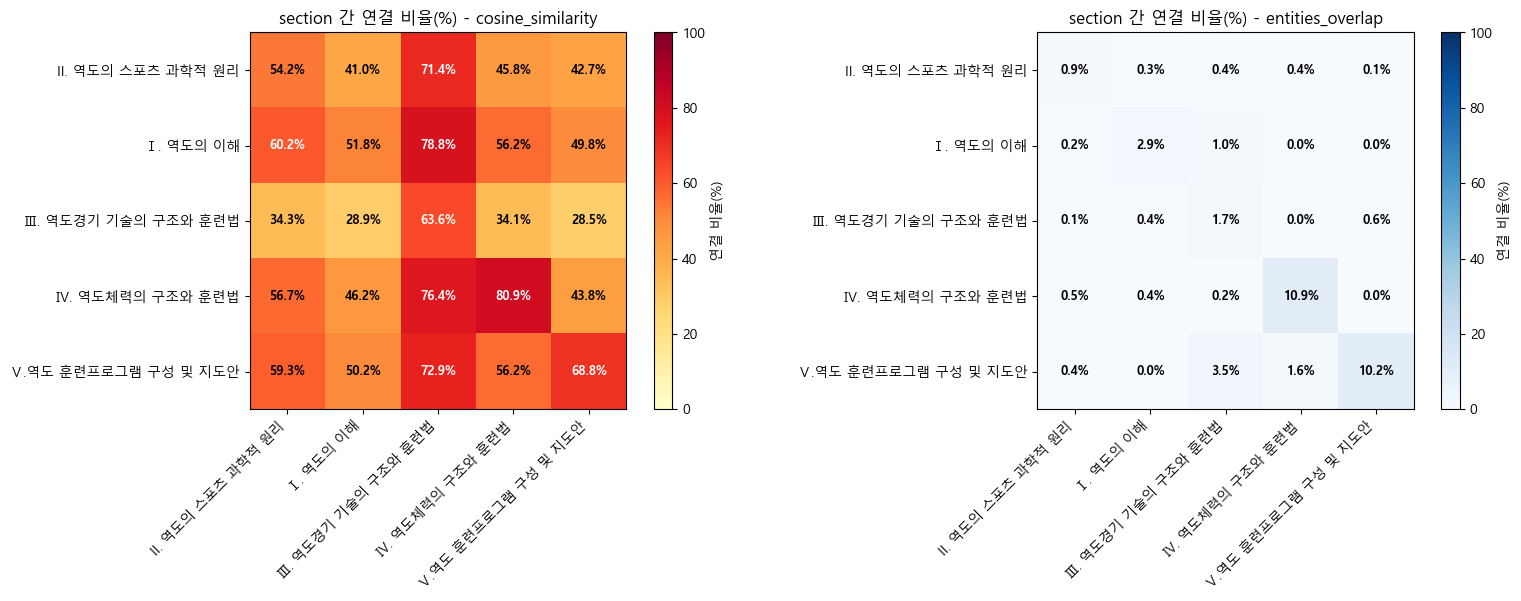

In [19]:
dfs = analyze_sector_connection_ratio(
    kg,
    color_maps={'cosine_similarity': 'YlOrRd',  # Yellow-Orange-Red
                'entities_overlap': 'Blues'}    # Blue 계열
)

## Cosine_Similarity relationship 
* threshold를 0.88으로 설정
* 기존 0.7 설정의 경우 타 섹션의 비율이 동일 섹션 대비 압도적으로 많음
* 0.88 기준 타 섹션이 금감하는 시점으로, 실제 의미있는 관계일 가능성이 높음

In [20]:
cosine_rel = [rel for rel in kg.relationships if rel.type == 'cosine_similarity']
similarity_scores = [rel.properties['summary_similarity'] for rel in cosine_rel]
target_section = [rel.target.properties['document_metadata']['heading']['heading1'] for rel in cosine_rel]
source_section = [rel.source.properties['document_metadata']['heading']['heading1'] for rel in cosine_rel]

cosine_df = pd.DataFrame({
    'source_section': source_section,
    'target_section': target_section,
    'cosine_similarity': similarity_scores
})

cosine_df['intersection'] = cosine_df['source_section'] != cosine_df['target_section']


In [21]:
cosine_df.head(2)

,source_section,target_section,cosine_similarity,intersection
0,II. 역도의 스포츠 과학적 원리,II. 역도의 스포츠 과학적 원리,0.927541,False
1,Ⅰ. 역도의 이해,Ⅰ. 역도의 이해,0.913589,False


In [22]:
def plot_similarity_distributions(df, bins=50, figsize=(15, 10)):
    """
    cosine_similarity의 분포를 일반 히스토그램과 CDF로 시각화합니다.
    
    Args:
        df (pd.DataFrame): cosine_similarity와 intersection 컬럼이 있는 데이터프레임
        bins (int): 히스토그램의 bin 개수
        figsize (tuple): 그래프 크기
    """
    # 데이터 준비
    data_dict = {
        '전체': df['cosine_similarity'],
        'True': df[df['intersection'] == True]['cosine_similarity'],
        'False': df[df['intersection'] == False]['cosine_similarity']
    }
    
    # 그래프 설정
    plot_configs = [
        {'title': '전체 Cosine Similarity 히스토그램', 'cumulative': False, 'single': True},
        {'title': '전체 Cosine Similarity 누적 분포', 'cumulative': True, 'single': True},
        {'title': 'Intersection별 Cosine Similarity 히스토그램', 'cumulative': False, 'single': False},
        {'title': 'Intersection별 Cosine Similarity 누적 분포', 'cumulative': True, 'single': False}
    ]
    
    # 2x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    # 각 서브플롯 그리기
    for idx, (ax, config) in enumerate(zip(axes, plot_configs)):
        if config['single']:
            # 전체 데이터만 그리기
            ax.hist(data_dict['전체'], bins=bins, color='skyblue', 
                   edgecolor='black', alpha=0.7, cumulative=config['cumulative'])
        else:
            # True/False 데이터 그리기
            for label, color in [('True', 'green'), ('False', 'red')]:
                ax.hist(data_dict[label], bins=bins, color=color, 
                       edgecolor='black', alpha=0.5, label=label,
                       cumulative=config['cumulative'])
            ax.legend()
        
        ax.set_title(config['title'])
        ax.set_xlabel("Cosine Similarity")
        ax.set_ylabel("누적 빈도" if config['cumulative'] else "빈도")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

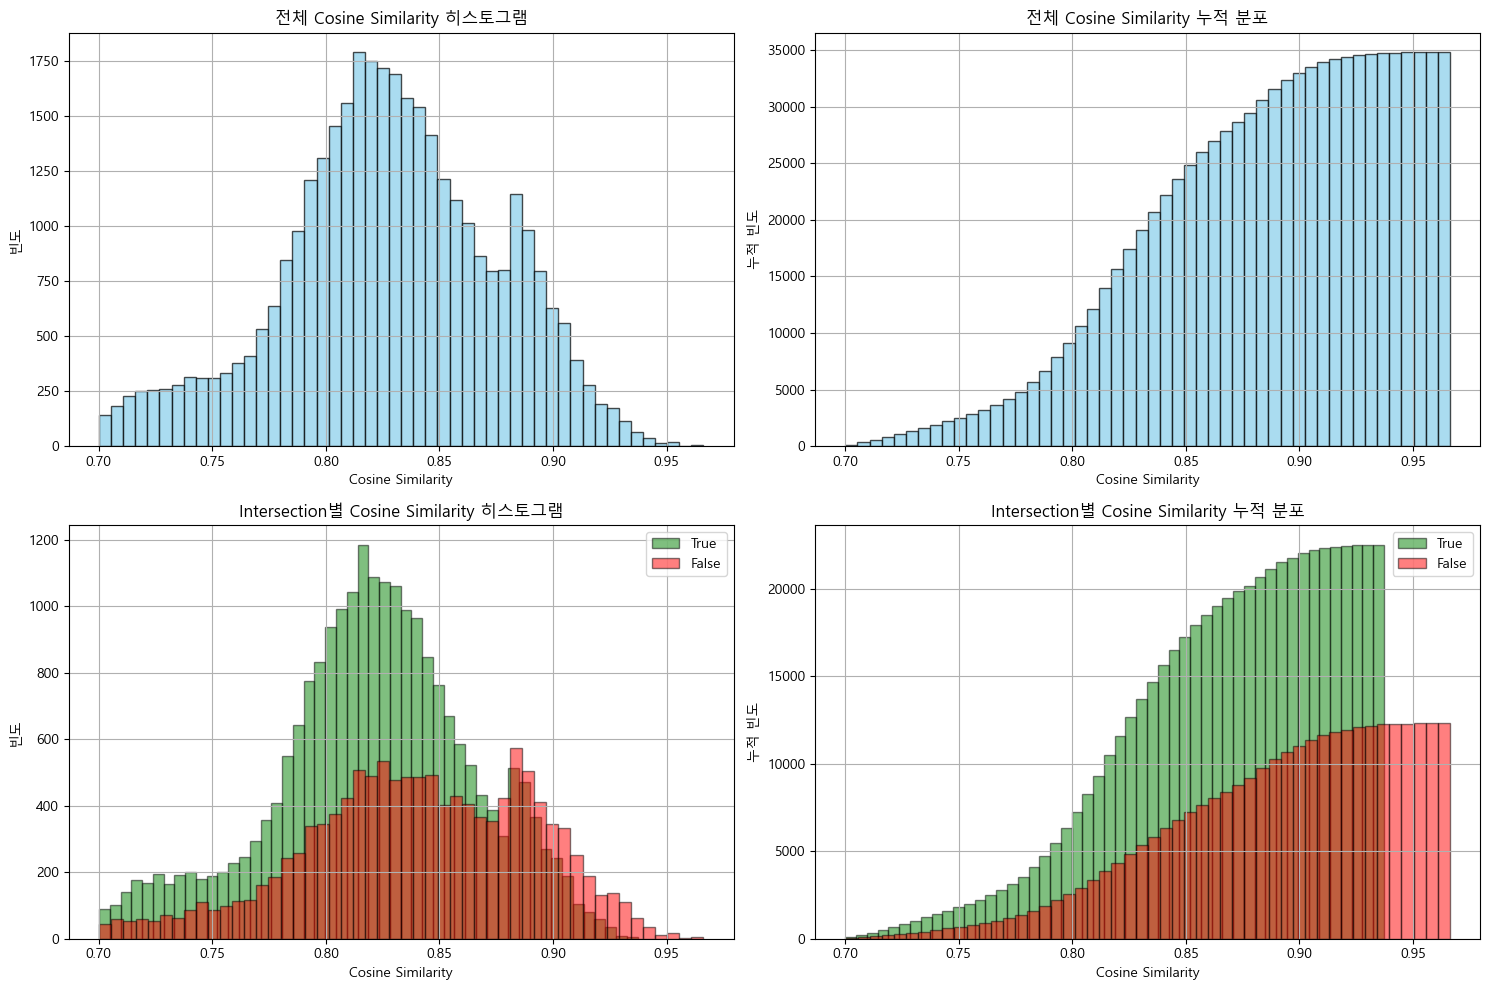

In [23]:
# stats = plot_similarity_distributions(cosine_df)

In [77]:
tmp_df = cosine_df.loc[cosine_df['cosine_similarity'] >= 0.88]
tmp = tmp_df.groupby('intersection').agg({'cosine_similarity': 'mean', 'source_section': 'count'}).reset_index().rename(columns={'source_section': 'count'})
tmp['ratio'] = round(tmp['count'] / tmp['count'].sum() * 100, 2)

tmp

,intersection,cosine_similarity,count,ratio
0,False,0.900629,1644,58.05
1,True,0.894662,1188,41.95


In [80]:
rel_list = []
for rel in kg.relationships:
    if rel.type != 'cosine_similarity':
        rel_list.append(rel)
    if rel.type == 'cosine_similarity':
        if rel.properties['summary_similarity'] >= 0.88:
            rel_list.append(rel)

kg.relationships = rel_list
kg.save('../data/rag/kg.json')

## 3. MultiHopAbstractQuerySunthesizer 최적화

In [11]:
from typing import Dict, List, Tuple, Union
from dataclasses import dataclass, field

import typing as t
import logging
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
from ragas.testset.graph import KnowledgeGraph, Node

from ragas.testset.synthesizers.multi_hop import MultiHopScenario
from ragas.testset.synthesizers.multi_hop.abstract import MultiHopAbstractQuerySynthesizer
from ragas.testset.synthesizers.single_hop.specific import SingleHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.specific import MultiHopSpecificQuerySynthesizer

from ragas.testset import TestsetGenerator


logger = logging.getLogger(__name__)

@dataclass
class FastMultiHopAbstractQuerySynthesizer(MultiHopAbstractQuerySynthesizer):
    name: str = "fast_multi_hop_abstract_synthesizer"

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._neighbor_cache = {}
        self._cluster_cache = {}
        
    def _build_neighbor_map(self, knowledge_graph: KnowledgeGraph) -> dict:
        """선처리: 노드별 이웃 노드 맵 생성"""
        if not self._neighbor_cache:
            neighbor_map = defaultdict(set)
            # 한 번의 순회로 모든 관계 처리
            for rel in knowledge_graph.relationships:
                if rel.get_property("summary_similarity"):
                    neighbor_map[rel.source].add(rel.target)
            self._neighbor_cache = dict(neighbor_map)
        return self._neighbor_cache

    def _find_cluster_from_node(self, start_node: Node, neighbor_map: dict, max_depth: int = 2) -> set:
        """단일 노드에서 시작하는 클러스터 찾기"""
        # 캐시 확인
        cache_key = (start_node.id, max_depth)
        if cache_key in self._cluster_cache:
            return self._cluster_cache[cache_key]

        visited = {start_node}
        current_level = {start_node}
        
        # BFS 사용 (더 효율적인 메모리 사용)
        for depth in range(max_depth):
            next_level = set()
            for node in current_level:
                neighbors = neighbor_map.get(node, set())
                next_level.update(n for n in neighbors if n not in visited)
            visited.update(next_level)
            current_level = next_level
            if not current_level:  # 더 이상 확장할 노드가 없으면 중단
                break

        # 결과 캐싱
        self._cluster_cache[cache_key] = visited
        return visited

    def get_node_clusters(self, knowledge_graph: KnowledgeGraph) -> t.List[t.Set[Node]]:
        """최적화된 클러스터 찾기"""
        # 1. 이웃 노드 맵 구축 (캐시 활용)
        neighbor_map = self._build_neighbor_map(knowledge_graph)
        
        # 2. 병렬 처리를 위한 함수
        def process_node_chunk(nodes):
            return [self._find_cluster_from_node(node, neighbor_map) for node in nodes]

        # 3. 노드를 청크로 분할하여 병렬 처리
        chunk_size = max(1, len(knowledge_graph.nodes) // (4 * 2))  # CPU 코어 수의 2배 정도의 청크
        node_chunks = [
            list(knowledge_graph.nodes)[i:i + chunk_size]
            for i in range(0, len(knowledge_graph.nodes), chunk_size)
        ]

        # 4. 병렬 처리 실행
        all_clusters = []
        with ThreadPoolExecutor(max_workers=4) as executor:
            chunk_results = list(executor.map(process_node_chunk, node_chunks))
            for chunk_result in chunk_results:
                all_clusters.extend(chunk_result)

        # 5. 중복 제거 및 최소 크기 필터링 (set 연산 사용)
        unique_clusters = set()
        min_cluster_size = 2  # 최소 클러스터 크기 설정
        
        for cluster in all_clusters:
            if len(cluster) >= min_cluster_size:
                frozen_cluster = frozenset(cluster)
                unique_clusters.add(frozen_cluster)

        logger.info(f"Found {len(unique_clusters)} unique clusters")
        return [set(cluster) for cluster in unique_clusters]

## 4. presona 분석
* 생성 페르소나 결과(8개)
  * 스포츠 심리학자: 선수 개인과 팀의 역학에 맞춘 심리 훈련을 통해 정신적 기술과 경기력을 향상시킵니다.
  * 근력 트레이닝 코치: 리프팅 기술과 근육 활용에 중점을 두어 선수들의 경기력을 최적화합니다.
  * 스포츠 역사학자: 올림픽을 중심으로 선수들과 스포츠 이벤트의 역사와 업적을 연구하고 기록합니다.
  * 근력 트레이닝 코치: 선수들에게 효과적인 역도를 위한 올바른 기술과 근육 활용법을 교육합니다.
  * 근력 트레이닝 코치: 선수들의 리프팅 기술 향상과 근육 활용 최적화를 지도합니다.
  * 경기용 역도 코치: 선수들이 리프팅 기술을 최적화하고 근육 활용도를 높일 수 있도록 전문적으로 지도합니다.
  * 역도 코치: 선수들에게 최적의 경기력을 위한 올바른 리프팅 기술과 근육 활용법을 훈련시킵니다.
  * 스포츠 역사학자: 선수들의 주요 성과와 스포츠의 이정표를 중심으로 경쟁 스포츠의 역사를 연구하고 기록합니다.
* 시사점
  * generate_personas_from_kg 설명
    * 문서의 summary_embedding 값을 활용하여 cosine_similarities 기반 클러스터링을 생성
    * cosine_similarities가 0.75 이상인 요약을 하나의 요약으로 생성
    * 각 그룹에서 가장 긴 요약을 대표 요약으로 선정
    * 대표 요약을 기반으로 해당 콘텐트와 상호작용하거나 혜택을 받을 가능성이 있는 단일 페르소나를 생성
  * generate_persona_from_kg 결과가 실제 예상 사용자와 큰 차이를 보임

In [12]:
import pickle
from ragas.testset.persona import generate_personas_from_kg

# personas = generate_personas_from_kg(kg=kg, llm=generator_llm, num_personas=8)
# pickle.dump(personas, open('../data/rag/personas.pkl', 'wb'))

personas = pickle.load(open('../data/rag/personas.pkl', 'rb'))

In [13]:
personas

[Persona(name='Sports Psychologist', role_description='Works with athletes to enhance mental skills and performance by tailoring psychological training to individual and team dynamics.'),
 Persona(name='Strength Training Coach', role_description='Trains athletes by focusing on lifting techniques and muscle engagement for optimal performance.'),
 Persona(name='Sports Historian', role_description='Researches and documents the history and achievements of athletes and sporting events, with a focus on Olympic competitions.'),
 Persona(name='Strength Training Coach', role_description='Specializes in teaching athletes the proper techniques and muscle engagement for effective weightlifting.'),
 Persona(name='Strength Training Coach', role_description='Guides athletes in improving their lifting techniques and enhancing muscle engagement for optimal performance.'),
 Persona(name='Competitive Weightlifting Coach', role_description='Guides athletes in optimizing their lifting techniques and improv

### default_distribution 기반의 합성 데이터셋 생성

In [14]:
query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.3),
    (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.3),
    (FastMultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.4)
]


generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    knowledge_graph=kg,
    persona_list=personas,
)

testset = generator.generate(testset_size=40, query_distribution=query_distribution)
basic_dataset = testset.to_pandas()
basic_dataset.to_csv('../data/rag/basic_dataset.csv', index=False)

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=f156c581-71da-4a53-975a-a98818cecee3,id=f156c581-71da-4a53-975a-a98818cecee3; trace=f156c581-71da-4a53-975a-a98818cecee3,id=022d736b-c189-4137-ae8f-b7ad274626d2; trace=f156c581-71da-4a53-975a-a98818cecee3,id=c771dc1a-452a-4527-b7ed-393e7d7435c5; trace=f156c581-71da-4a53-975a-a98818cecee3,id=9d229ecf-8859-4679-bd22-b07cbca4f081; trace=f156c581-71da-4a53-975a-a98818cecee3,id=87fc2136-e0d7-4d09-8971-c618a6af322b; trace=f156c581-71da-4a53-975a-a98818cecee3,id=b20e53e3-8719-4759-bba5-383a1876b4d3; trace=f156c581-71da-4a53-975a-a98818cecee3,id=9da35110-df1c-4c3c-8be6-b4240001

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=f156c581-71da-4a53-975a-a98818cecee3,id=1513a577-4268-475d-b97a-001dbeeefb71; trace=f156c581-71da-4a53-975a-a98818cecee3,id=d97d17f0-9bbc-46db-8e77-3e4e97a0357a; trace=f156c581-71da-4a53-975a-a98818cecee3,id=96ee1fb7-6e05-49e1-935e-ee306df7bd61; trace=f156c581-71da-4a53-975a-a98818cecee3,id=6dce1707-956a-4886-b2f9-8521feb1535b; trace=f156c581-71da-4a53-975a-a98818cecee3,id=f156c581-71da-4a53-975a-a98818cecee3
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url

## 5. 번역

In [16]:
import re
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def classify_language(text):
    english_count = len(re.findall(r'[a-zA-Z]', text))
    korean_count = len(re.findall(r'[가-힣]', text))

    if english_count >= korean_count:
        return 'english'

    return 'korean'


def translate(testset_df):
    template = """
        You are an expert translator specializing in English to Korean translation.

        Translate the following English text into natural Korean.  
        Only output the translated Korean text.  
        If a term is a proper noun or a commonly used English term (e.g., "clean and jerk"), transliterate it into Korean and include the original English in parentheses.

        Text:  
        {input_text}
    """ 

    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    prompt = PromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    testset_df['language_user_input'] = testset_df['user_input'].apply(lambda x : classify_language(x))
    testset_df['language_reference'] = testset_df['reference'].apply(lambda x : classify_language(x))

    user_data = testset_df.loc[(testset_df['language_user_input'] == 'english'), 'user_input'].tolist()
    reference_data = testset_df.loc[(testset_df['language_reference'] == 'english'), 'reference'].tolist()

    translate_user = chain.batch(user_data, config={'max_concurrency': 5})
    translate_reference = chain.batch(reference_data, config={'max_concurrency': 5})

    testset_df.loc[(testset_df['language_user_input'] == 'english'), 'user_input'] = translate_user
    testset_df.loc[(testset_df['language_reference'] == 'english'), 'reference'] = translate_reference

    return testset_df.iloc[:, :4]

In [17]:
import re 

def make_chunk_dict(knowledge_graph, heading: str = 'heading1'):
    chunk_dict = {}
    chunk_id_dict = {}
    chunk_summary_embedding = {}
    for node in knowledge_graph.nodes:
        section = node.properties['document_metadata']['heading'][heading]
        chunk_id = node.properties['document_metadata']['chunk_id']
        summary_embedding = node.properties['summary_embedding']
        page_content = node.properties['page_content']

        chunk_dict[page_content] = section
        chunk_id_dict[page_content] = chunk_id
        chunk_summary_embedding[page_content] = summary_embedding
    return chunk_dict, chunk_id_dict, chunk_summary_embedding

def regular_expression(reference_contexts, chunk_dict):
    if len(reference_contexts) == 1:
        return [chunk_dict[reference_contexts[0]]]
    else:
        return [chunk_dict[re.sub(r"<\d+-hop>\n\n", "", text)] for text in reference_contexts] 
    
    
def analyze_synthetic_data(kg, testset_df, heading:str = 'heading1'):
    chunk_dict, chunk_id_dict, chunk_summary_embedding = make_chunk_dict(kg)
    testset_df['reference_contexts_section'] = testset_df['reference_contexts'].apply(lambda x : regular_expression(x, chunk_dict))
    return testset_df

In [18]:
trans_df = translate(basic_dataset)
result = analyze_synthetic_data(kg, trans_df)
result['reference_contexts'] = result['reference_contexts'].apply(lambda x: [re.sub(r'<\d-hop>\n\n', '', context) for context in x])

In [19]:
basic_test = result.groupby(['synthesizer_name']).apply(lambda x : x.sample(n=int(len(x) * 0.3))).reset_index(drop=True)
basic_valid = result.drop(basic_test.index)

basic_test.to_csv('../data/rag/basic_testset.csv', index=False)
basic_valid.to_csv('../data/rag/basic_validset.csv', index=False)

C:\Users\owner\AppData\Local\Temp\ipykernel_26348\1039105968.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  basic_test = result.groupby(['synthesizer_name']).apply(lambda x : x.sample(n=int(len(x) * 0.3))).reset_index(drop=True)


In [20]:
basic_valid

,user_input,reference_contexts,reference,synthesizer_name,reference_contexts_section
10,저크동작(jerk)은 용상(olympic weightlifting) 대회에서 어떤 ...,[저크동작은 용상에만 있는 동작으로 클린에 비하여 실패율이 2배 이상 높아 용\n상...,저크동작은 용상에만 있는 동작으로 클린에 비하여 실패율이 2배 이상 높아 용상경기의...,single_hop_specifc_query_synthesizer,[II. 역도의 스포츠 과학적 원리]
11,역도에서 스플릿 저크 밸런스(Split Jerk Balance) 기술의 주요 단계는...,[이미지는 역도 기술 중 하나인 Split Jerk Balance의 전면 모습을 세...,스플릿 저크 밸런스(Split Jerk Balance) 기술은 세 가지 주요 단계로...,single_hop_specifc_query_synthesizer,[Ⅲ. 역도경기 기술의 구조와 훈련법]
12,운동기능과 운동제어의 원리가 스포츠심리학에서 확인된 심리적 요인들과 어떻게 관련이 ...,"[운동발달은 인간의 성장, 발달에 따른 운동기능의 변화 경향을 분석해 서로 다\n른...","운동기능과 운동제어는 스포츠심리학에서 확인된 심리적 요인들과 상호 연결되어 있으며,...",multi_hop_specific_query_synthesizer,"[II. 역도의 스포츠 과학적 원리, II. 역도의 스포츠 과학적 원리]"
13,"프로그램 B의 중요성은 고급 역도 훈련의 맥락에서 무엇이며, 그것이 심리적 기술 훈...","['45도 Incline Press'와 'Power snatch, Clean' 운동...","프로그램 B는 고급 역도 훈련의 맥락에서 중요하며, 엘리트 역도 선수들을 위해 설계...",multi_hop_specific_query_synthesizer,"[Ⅴ.역도 훈련프로그램 구성 및 지도안, II. 역도의 스포츠 과학적 원리]"
14,"개별 특성에 대한 이해가 힘 훈련, 특히 저크 기술(jerk technique)에서...",[Jerk의 기술동작은 클린동작이 끝나고 시작자세에서 바벨을 가슴위에 올려놓고\n구...,힘 훈련에서 개인의 특성을 이해하는 것은 특히 저크(jerk) 기술에서 매우 중요합...,multi_hop_specific_query_synthesizer,"[Ⅲ. 역도경기 기술의 구조와 훈련법, II. 역도의 스포츠 과학적 원리]"
15,"2009년 세계선수권대회에서 한국 선수와 중국 선수의 역도 동작을 비교할 때, 한국...",[이미지에는 역도 선수가 바벨을 들어 올리는 일련의 동작이 순서대로 나타나 있다. ...,2009년 세계선수권대회에서 한국 선수는 저크를 하기 전 단계인 일어서기 동작에서 ...,multi_hop_specific_query_synthesizer,"[Ⅲ. 역도경기 기술의 구조와 훈련법, Ⅲ. 역도경기 기술의 구조와 훈련법]"
16,"민첩성(agility)은 역도 선수들의 전반적인 신체 능력에서 어떤 역할을 하며, ...",[아래에 제시한 체력의 요소들은 현장에서 일반적으로 행하고 있고 역도기초체력\n을 ...,"민첩성은 역도 선수의 전반적인 신체 능력에서 중요한 역할을 하며, 이는 기본적인 신...",multi_hop_specific_query_synthesizer,"[Ⅳ. 역도체력의 구조와 훈련법, Ⅰ. 역도의 이해]"
17,스내치(Snatch) 기술에서 동적 시작 자세와 정적 시작 자세의 주요 차이점은 무...,[인상의(snatch)의 종류에는 크게 Squat Snatch와 Split Snat...,스내치(snatch) 기술에서 시작 자세는 동적(dynamic) 또는 정적(stat...,multi_hop_specific_query_synthesizer,"[Ⅲ. 역도경기 기술의 구조와 훈련법, Ⅲ. 역도경기 기술의 구조와 훈련법]"
18,중국 선수들과 한국 선수들 간의 리프팅 기술에서의 주요 차이점은 무엇인가요? 특히 ...,[앉아받기 동작이 끝나고 일어서기 자세는 저크를 하기 바로 전 단계로 정의한다. 용...,중국 선수들과 한국 선수들 간의 리프팅 기술의 주요 차이점은 훈련 세션에서 관찰된 ...,multi_hop_specific_query_synthesizer,"[Ⅲ. 역도경기 기술의 구조와 훈련법, II. 역도의 스포츠 과학적 원리]"
19,"단기 훈련 계획에서 훈련 부하와 강도의 중요성은 무엇이며, 심리 기술 훈련을 훈련 ...",[이완기간은 시합기간과 다음의 준비기간 사이의 기간으로서 선수에게 활동적인\n휴식을...,훈련 부하와 강도의 중요성은 운동선수를 위한 단기 훈련 계획에서 매우 중요합니다. ...,multi_hop_specific_query_synthesizer,"[Ⅴ.역도 훈련프로그램 구성 및 지도안, II. 역도의 스포츠 과학적 원리]"
